In [1]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
%matplotlib inline

In [2]:
h=fits.open('C02_master_merged.fits')
mag=25-2.5*np.log10(h[1].data['Total_flux'])
RA,Dec=h[1].data['RA']*u.radian,h[1].data['DEC']*u.radian
RA,Dec=RA.to(u.deg),Dec.to(u.deg)

#Ensure all targets are unique
unq=np.unique(RA*Dec,return_index=True)[1]
RA,Dec,mag=RA[unq],Dec[unq],mag[unq]

In [3]:
import pickle
targlist=pickle.load(open('xmatch.p','rb'))

In [4]:
EPICcatalog=SkyCoord(targlist.k2_ra*u.deg,targlist.k2_dec*u.deg)

In [5]:
INPUTcatalog = SkyCoord(ra=RA, dec=Dec)

In [6]:
depth=5

In [46]:
columns=['RA','Dec','InputMag']
preffixes=['EPICKpMag_','EPICdKpMag_','EPICd2d_','EPICRA_','EPICDec_','EPICID_','KepFlag_']
for i in np.arange(depth)+1:
    for p in preffixes:
        columns.append('{}{}'.format(p,i))
[columns.append(i) for i in ['Nth_Neighbour','Xflag','EPICID','KpMag']]

results=pd.DataFrame(columns=columns)
print results.keys()
results['RA']=RA
results['Dec']=Dec
results['InputMag']=mag
results['Nth_Neighbour']=0
results['Xflag']=-1

Index([u'RA', u'Dec', u'InputMag', u'EPICKpMag_1', u'EPICdKpMag_1',
       u'EPICd2d_1', u'EPICRA_1', u'EPICDec_1', u'EPICID_1', u'KepFlag_1',
       u'EPICKpMag_2', u'EPICdKpMag_2', u'EPICd2d_2', u'EPICRA_2',
       u'EPICDec_2', u'EPICID_2', u'KepFlag_2', u'EPICKpMag_3',
       u'EPICdKpMag_3', u'EPICd2d_3', u'EPICRA_3', u'EPICDec_3', u'EPICID_3',
       u'KepFlag_3', u'EPICKpMag_4', u'EPICdKpMag_4', u'EPICd2d_4',
       u'EPICRA_4', u'EPICDec_4', u'EPICID_4', u'KepFlag_4', u'EPICKpMag_5',
       u'EPICdKpMag_5', u'EPICd2d_5', u'EPICRA_5', u'EPICDec_5', u'EPICID_5',
       u'KepFlag_5', u'Nth_Neighbour', u'Xflag', u'EPICID', u'KpMag'],
      dtype='object')


In [55]:
for n in np.arange(depth)+1:
    idx, d2d, d3d = INPUTcatalog.match_to_catalog_sky(EPICcatalog,nthneighbor=n)  
    gri=np.where(np.asarray(targlist.kepflag)[idx]=='gri')[0]
    if n==1:
        zeropoint=np.median(np.asarray(targlist.kp)[idx][gri]-mag[gri])

    pos=np.arange(np.where(results.columns == '{}{}'.format(preffixes[0],n))[0][0],np.where(results.columns == '{}{}'.format(preffixes[-1],n))[0][0]+1)
    nkeys=results.keys()[pos]
    ar=np.transpose([targlist.kp[idx],
                     targlist.kp[idx]-(mag+zeropoint),
                     d2d.to(u.arcsecond).value,
                     targlist.k2_ra[idx],
                     targlist.k2_dec[idx],
                     targlist.id[idx],
                     targlist.kepflag[idx]])
    results[nkeys]=ar
    

In [59]:
results.to_pickle('results.p')

In [3]:
results=pd.read_pickle('results.p')
preffixes=['EPICKpMag_','EPICdKpMag_','EPICd2d_','EPICRA_','EPICDec_','EPICID_','KepFlag_']
depth=5

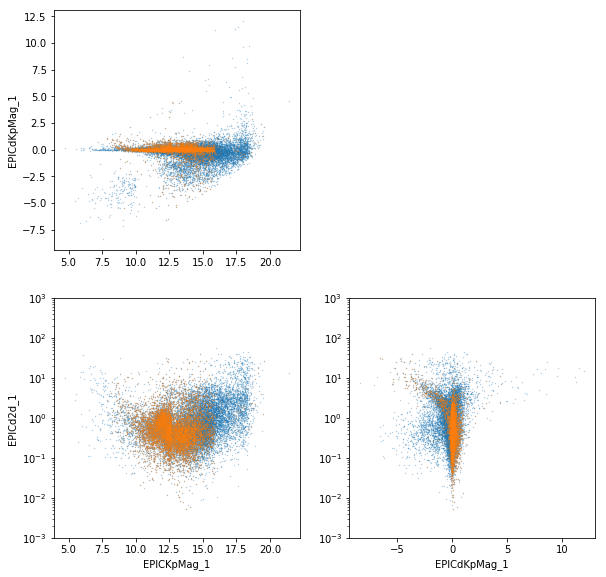

In [4]:
n=1
keys=['{}{}'.format(preffixes[0],n),'{}{}'.format(preffixes[1],n),'{}{}'.format(preffixes[2],n)]
fig,ax=plt.subplots(len(keys),len(keys),figsize=(15,15))
for i in xrange(len(keys)):
    for j in xrange(len(keys)):
        if j>=i:
            fig.delaxes(ax[i,j])
            continue
        ax[i,j].scatter(results[keys[j]],results[keys[i]],s=0.1,alpha=0.5)
        pos=results['{}{}'.format('KepFlag_',n)]=='gri'
        ax[i,j].scatter(results[keys[j]][pos],results[keys[i]][pos],s=0.1,alpha=0.5)
        if j==0:
            ax[i,j].set_ylabel(keys[i])
        if i==len(keys)-1:
            ax[i,j].set_xlabel(keys[j])
        
        if keys[j].startswith('EPICd2d'):
            ax[i,j].set_xscale('log')
        if keys[i].startswith('EPICd2d'):
            ax[i,j].set_yscale('log')
            ax[i,j].set_ylim(1E-3,1E3)
            
        
            
pos=results['{}{}'.format('KepFlag_',n)]=='gri'


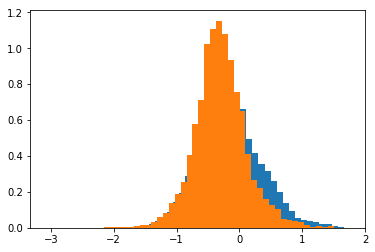

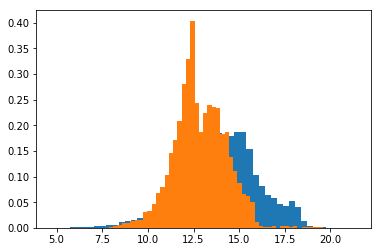

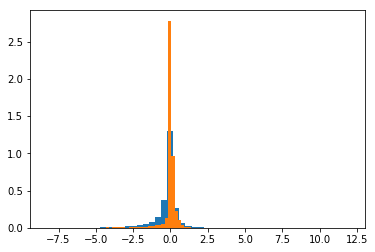

In [6]:
pos=results['{}{}'.format('KepFlag_',n)]=='gri'        

plt.figure()
_=plt.hist(np.log10(results['EPICd2d_1']),50,normed=True)
_=plt.hist(np.log10(results['EPICd2d_1'][pos]),50,normed=True)

plt.figure()
_=plt.hist((results['EPICKpMag_1']),50,normed=True)
_=plt.hist((results['EPICKpMag_1'][pos]),50,normed=True)

plt.figure()
_=plt.hist((results['EPICdKpMag_1']),50,normed=True)
_=plt.hist((results['EPICdKpMag_1'][pos]),50,normed=True)

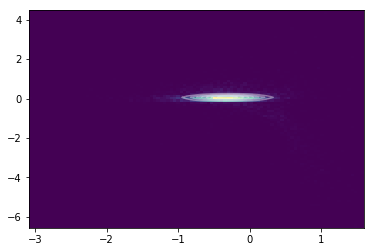

In [7]:
pos=results['{}{}'.format('KepFlag_',1)]=='gri'    
H=plt.hist2d(np.log10(results.EPICd2d_1[pos]),results.EPICdKpMag_1[pos],100,normed=True)
from astropy.modeling import models, fitting
X,Y=np.meshgrid(H[1][:-1]+np.median(H[1][1:]-H[1][0:-1]),H[2][:-1]+np.median(H[2][1:]-H[2][0:-1]))
p_init = models.Gaussian2D()
fit_p = fitting.LevMarLSQFitter()
p_gri = fit_p(p_init, X, Y, H[0].T)
plt.contour(X,Y,p_gri(X,Y),colors='white',alpha=0.4)

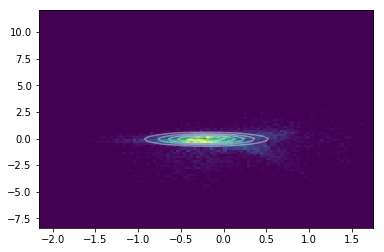

In [8]:
pos=results['{}{}'.format('KepFlag_',1)]!='gri'    
H=plt.hist2d(np.log10(results.EPICd2d_1[pos]),results.EPICdKpMag_1[pos],100,normed=True)
from astropy.modeling import models, fitting
X,Y=np.meshgrid(H[1][:-1]+np.median(H[1][1:]-H[1][0:-1]),H[2][:-1]+np.median(H[2][1:]-H[2][0:-1]))
p_init = models.Gaussian2D()
fit_p = fitting.LevMarLSQFitter()
p_ngri = fit_p(p_init, X, Y, H[0].T)
plt.contour(X,Y,p_ngri(X,Y),colors='white',alpha=0.4)

In [9]:
gri_corr=float(len(results[results['{}{}'.format('KepFlag_',1)]=='gri'  ]))/float(len(results))
ngri_corr=float(len(results[results['{}{}'.format('KepFlag_',1)]!='gri'  ]))/float(len(results))

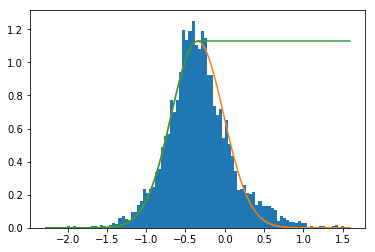

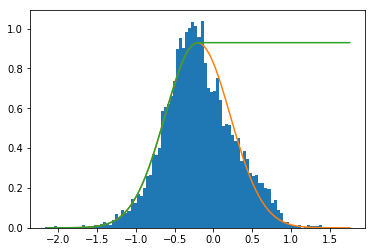

In [10]:
def prior(x,mu,sig,amp):
    def gaussian(x, mu, sig,amp):
        return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    if isinstance(x,float) == True:
        x=[x]
    result=[]
    for i in x:
        if i<=mu:
            result.append(gaussian(i,mu,sig,amp))
        else:
            result.append(1.*amp)
    return np.asarray(result)


pos=(results['{}{}'.format('KepFlag_',1)]=='gri')&(results.EPICKpMag_1<16)&(results.EPICKpMag_1>12) 
h=plt.hist(np.log10(results.EPICd2d_1[pos]),100,normed=True)
x=h[1][:-1]+np.median(h[1][1:]-h[1][0:-1])
p_init = models.Gaussian1D()
p_prior_gri = fit_p(p_init, x,h[0])
plt.plot(x,p_prior_gri(x))

plt.plot(x,prior(x,p_prior_gri.mean.value,p_prior_gri.stddev.value,p_prior_gri.amplitude.value))

plt.figure()
pos=(results['{}{}'.format('KepFlag_',1)]!='gri')&(results.EPICKpMag_1<16)&(results.EPICKpMag_1>12) 
h=plt.hist(np.log10(results.EPICd2d_1[pos]),100,normed=True)
x=h[1][:-1]+np.median(h[1][1:]-h[1][0:-1])
p_init = models.Gaussian1D()
p_prior_ngri = fit_p(p_init, x,h[0])
plt.plot(x,p_prior_ngri(x))

plt.plot(x,prior(x,p_prior_ngri.mean.value,p_prior_ngri.stddev.value,p_prior_ngri.amplitude.value))

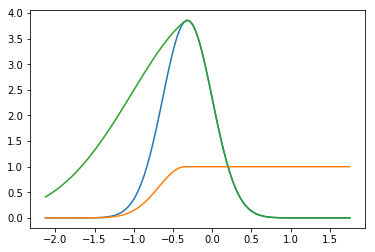

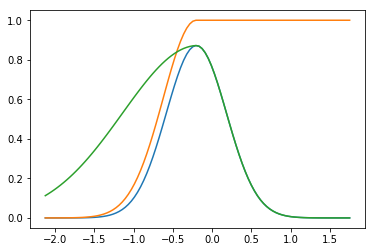

In [11]:
x=X[50]
plt.plot(x,p_gri(x,0))
plt.plot(x,prior(x,p_prior_gri.mean.value,p_prior_gri.stddev.value,1))
plt.plot(x,p_gri(x,0)/prior(x,p_prior_gri.mean.value,p_prior_gri.stddev.value,1))

plt.figure()

x=X[50]
plt.plot(x,p_ngri(x,0))
plt.plot(x,prior(x,p_prior_ngri.mean.value,p_prior_ngri.stddev.value,1))
plt.plot(x,p_ngri(x,0)/prior(x,p_prior_ngri.mean.value,p_prior_ngri.stddev.value,1))

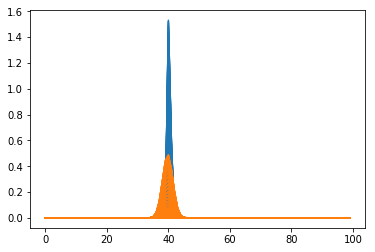

In [12]:
_=plt.plot(p_gri(X,Y)*gri_corr,color='C0')
_=plt.plot(p_ngri(X,Y)*ngri_corr,color='C1')

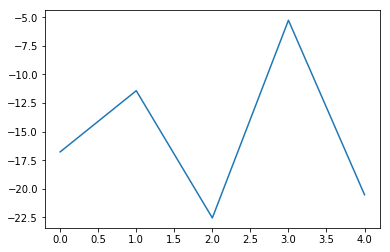

In [421]:
results=pd.read_pickle('results.p')
results['PROB']=0

for i in xrange(len(results)):
    probs,flags,ids=[],[],[]
    for n in np.arange(depth)+1:
            ra,dec,dist,dmag,col,epicid=results.loc[i,'EPICRA_{}'.format(n)],results.loc[i,'EPICDec_{}'.format(n)],results.loc[i,'EPICd2d_{}'.format(n)],results.loc[i,'EPICdKpMag_{}'.format(n)],results.loc[i,'KepFlag_{}'.format(n)],results.loc[i,'EPICID_{}'.format(n)]
            flags.append(col)
            ids.append(epicid)
            if col=='gri':
                prob=p_gri(np.log10(dist),dmag)*gri_corr
                prob/=prior(np.log10(dist),p_prior_gri.mean.value,p_prior_gri.stddev.value,1)
                probs.append(prob)
            if col!='gri':
                prob=p_ngri(np.log10(dist),dmag)*ngri_corr
                prob/=prior(np.log10(dist),p_prior_ngri.mean.value,p_prior_ngri.stddev.value,1)
                probs.append(prob)
    results.loc[i,'Nth_Neighbour']=np.argmax(probs)+1
    results.loc[i,'PROB']=np.max(probs)
    results.loc[i,'Xflag']=flags[np.argmax(probs)]
    results.loc[i,'EPICID']=ids[np.argmax(probs)]
    

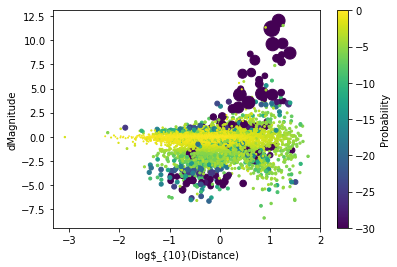

In [415]:
plt.scatter(np.log10(results.EPICd2d_1),results.EPICdKpMag_1,c=np.log10(results.PROB),s=-np.log10(results.PROB),vmax=0,vmin=-30)
plt.xlabel('log$_{10}(Distance)')
plt.ylabel('dMagnitude')
cbar=plt.colorbar()
cbar.set_label('Probability')

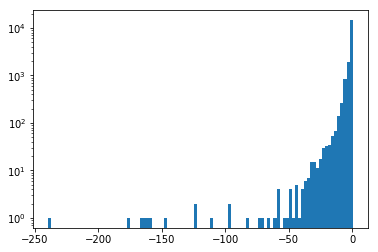

In [416]:
_=plt.hist(np.log10(results.PROB),100)
plt.yscale('log')

1279


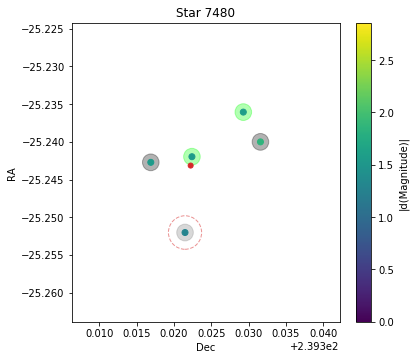

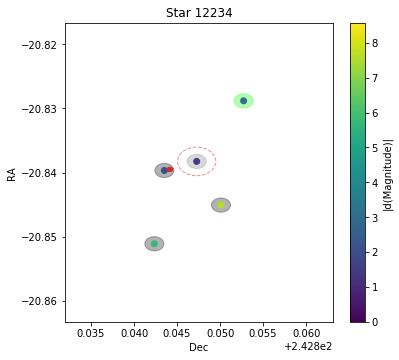

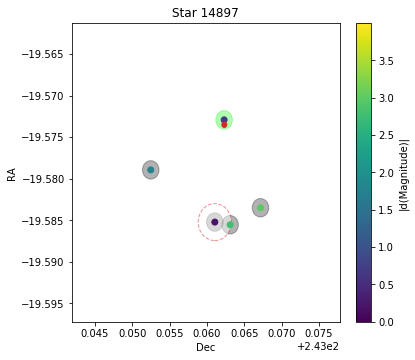

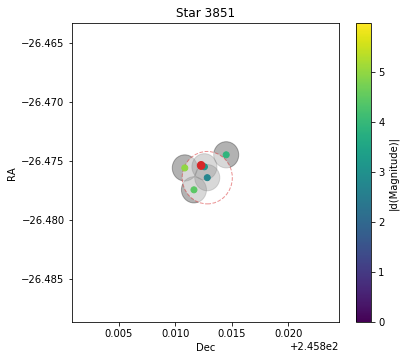

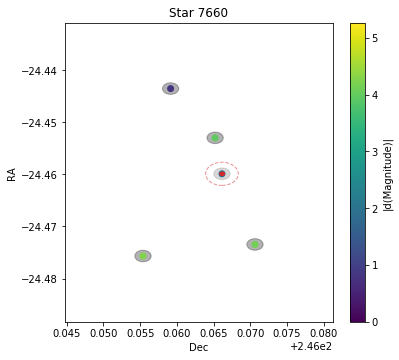

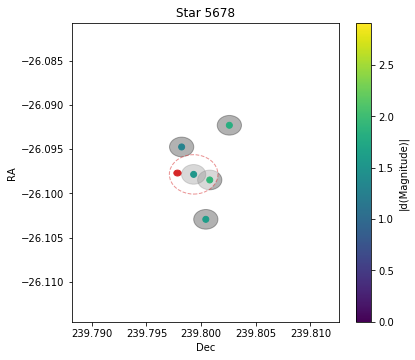

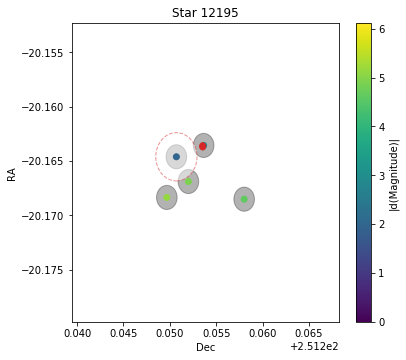

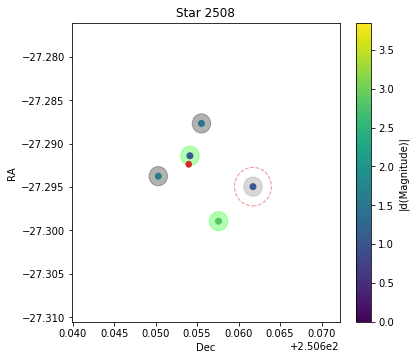

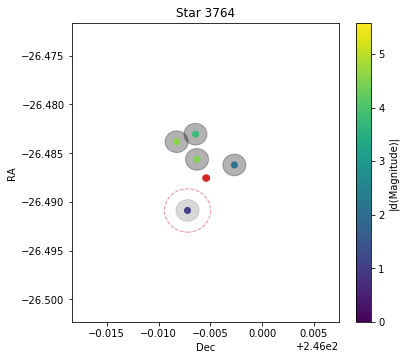

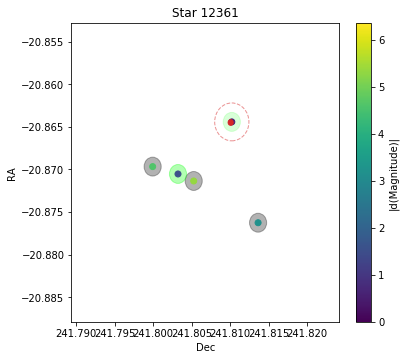

In [417]:
pos=np.where(np.log10(results.PROB)<=-5)[0]
print len(pos)
for j,i in enumerate(np.random.randint(0,len(pos),10)):
    s=starmap(pos[i])
#    s.savefig('starmap{}.png'.format(j),dpi=100,bbox_inches='tight')

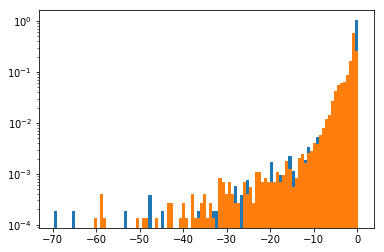

In [418]:
h=plt.hist(np.log10(results.PROB[results.Xflag=='gri']),100,normed=True)
plt.yscale('log')
_=plt.hist(np.log10(results.PROB[results.Xflag!='gri']),h[1],normed=True)




In [323]:
from matplotlib.patches import Circle
def starmap(i):
    def circle_scatter(axes, x_array, y_array, radius=0.5, **kwargs):
        for x, y in zip(x_array, y_array):
            circle = Circle((x,y), radius=radius, **kwargs)
            axes.add_patch(circle)
        return True
    
    fig,ax=plt.subplots(figsize=(6,5.5))
    cols,ras,decs=[],[],[]
    for n in np.arange(depth)+1:
        ra,dec,col,flag=results.loc[i,'EPICRA_{}'.format(n)],results.loc[i,'EPICDec_{}'.format(n)],results.loc[i,'EPICdKpMag_{}'.format(n)],results.loc[i,'KepFlag_{}'.format(n)]
        cols.append(np.abs(col))
        ras.append(ra)
        decs.append(dec)
        if flag=='gri':
            color='lime'
        if flag!='gri':
            color='black'
        
        #plt.text(ra+0.001,dec+0.001,'{}'.format(n),fontsize=15)
        circle_scatter(ax, [ra], [dec], radius=(4*u.arcsec).to(u.deg).value, alpha=0.3, color=color,zorder=-5)
    n=results.loc[i,'Nth_Neighbour']-1
    if n>-1:
        circle_scatter(ax, [ras[n]], [decs[n]], radius=(8*u.arcsec).to(u.deg).value, alpha=0.5, facecolor='white',edgecolor='C3',zorder=-1,ls='--')
    
    plt.scatter(ras,decs,c=cols,vmin=0,vmax=np.max(cols)+1)
    cbar=plt.colorbar()
    cbar.set_label('|d(Magnitude)|')
    circle_scatter(ax, [results.loc[i,'RA']], [results.loc[i,'Dec']], radius=(1.2*u.arcsec).to(u.deg).value, alpha=1, color='C3',zorder=1)
    plt.xlabel('Dec')
    plt.ylabel('RA')
    plt.title('Star {}'.format(i))
    return fig

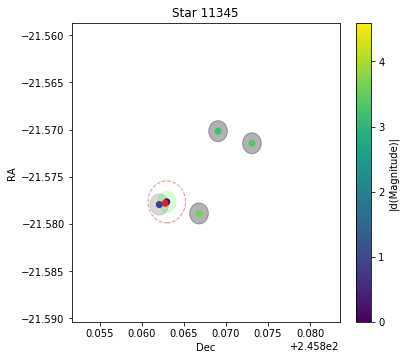

In [324]:
s=starmap(11345)

In [102]:
results=pd.read_pickle('results.p')

#Clear Matches
dist=4. #Closer than a pixel
dmag=1  #Less than a magnitude different


#No contaminants, close match
good=np.where((results.EPICd2d_1<=dist)&
              (results.EPICd2d_2>3*dist))[0]

results.Nth_Neighbour[good]=1


#Matches where any contaminant is a worse magnitude fit
good=np.where((results.Nth_Neighbour==0)&
              (results.EPICd2d_1<=dist)&
              (np.abs(results.EPICdKpMag_2)>=np.abs(results.EPICdKpMag_1)))[0]


results.Nth_Neighbour[good]=1

fairly_good=np.where((results.Nth_Neighbour==0)&
              ((results.EPICd2d_1)<=3*dist)&
              (np.abs(results.EPICdKpMag_1)<=dmag)&     
              ((results.EPICd2d_2)>=3*dist))[0]
results.Nth_Neighbour[fairly_good]=1




#Match is bad
bad=np.where((results.EPICd2d_1>=3*dist))[0]
results.Nth_Neighbour[bad]=-1




maybe=np.where((results.Nth_Neighbour==0)&
              (np.abs(results.EPICd2d_2)<=3*dist)&
              (np.abs(results.EPICdKpMag_2)<=np.abs(results.EPICdKpMag_1))&(np.abs(results.EPICdKpMag_2)<dmag))[0]
results.Nth_Neighbour[maybe]=2

maybe=np.where((results.Nth_Neighbour==0)&
              (np.abs(results.EPICd2d_3)<=3*dist)&
              (np.abs(results.EPICdKpMag_3)<=np.abs(results.EPICdKpMag_1))&
               (np.abs(results.EPICdKpMag_3)<=np.abs(results.EPICdKpMag_2))&
               (np.abs(results.EPICdKpMag_3)<dmag))[0]
results.Nth_Neighbour[maybe]=3

print float(len(results[results.Nth_Neighbour!=0]))/len(results)
print len(results)-len(results[results.Nth_Neighbour!=0]),' left'


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.963043116364
666  left


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [95]:
#Match is near enough, close enough in magnitude and there are no contaminants
fairly_good=np.where((results.Nth_Neighbour==0)&
              ((results.EPICd2d_1)<=3*dist)&
              (np.abs(results.EPICdKpMag_1)<=dmag)&     
              ((results.EPICd2d_2)>=3*dist))[0]
print len(fairly_good)

177


In [101]:
maybe=np.where((results.Nth_Neighbour==0)&
              (np.abs(results.EPICd2d_3)<=3*dist)&
              (np.abs(results.EPICdKpMag_3)<=np.abs(results.EPICdKpMag_1))&
               (np.abs(results.EPICdKpMag_3)<=np.abs(results.EPICdKpMag_2))&
               (np.abs(results.EPICdKpMag_3)<dmag))[0]
print len(maybe)


16


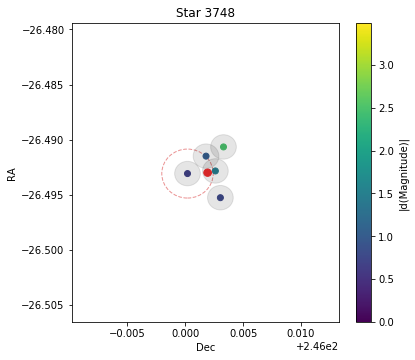

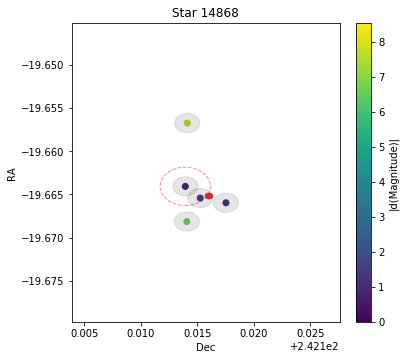

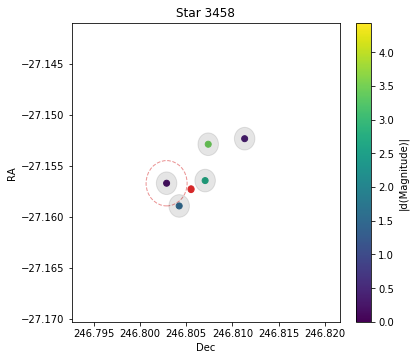

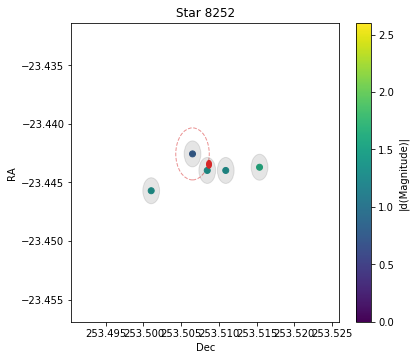

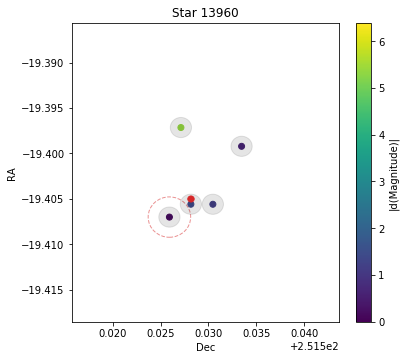

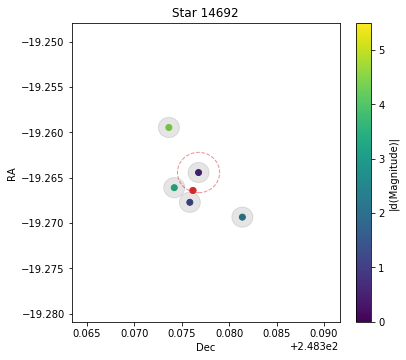

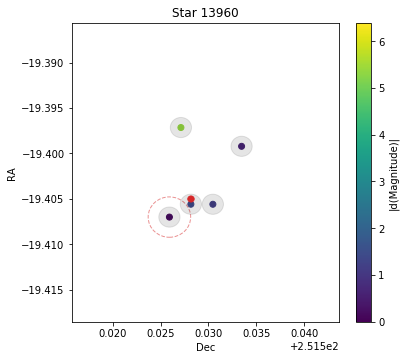

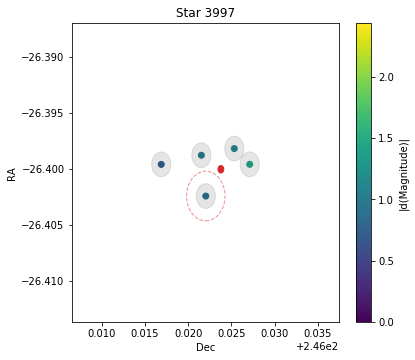

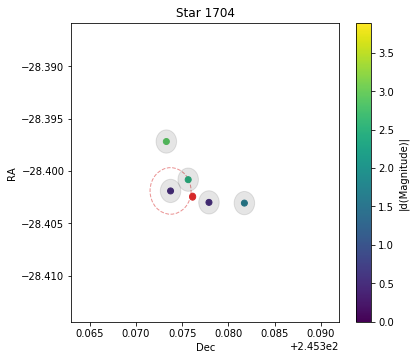

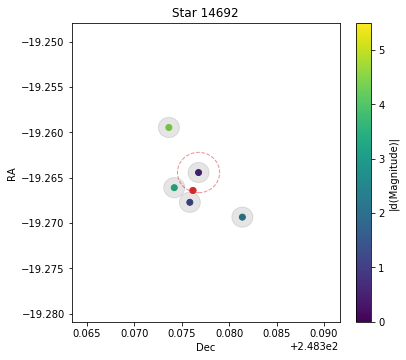

In [103]:
pos=maybe
for j,i in enumerate(np.random.randint(0,len(pos),10)):
    s=starmap(pos[i])
#    s.savefig('starmap{}.png'.format(j),dpi=100,bbox_inches='tight')

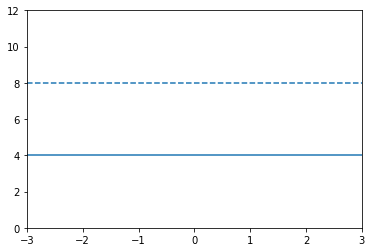

In [99]:
dists=results.loc[np.where(results.Nth_Neighbour==0)[0],['EPICd2d_1','EPICd2d_2','EPICd2d_3','EPICd2d_4','EPICd2d_5']].reset_index(drop=True)
mags=results.loc[np.where(results.Nth_Neighbour==0)[0],['EPICdKpMag_1','EPICdKpMag_2','EPICdKpMag_3','EPIdKpMag_4','EPICdKpMag_5']].reset_index(drop=True)

for d in xrange(len(dists)):
    d=2
    plt.scatter(np.asarray(mags.loc[d]),np.asarray(dists.loc[d]))
    plt.ylim(0,dist*3)
    plt.xlim(-3,3)
    plt.axhline(dist,ls='-')
    plt.axhline(2*dist,ls='--')


    break